SUMO 300 vehicles, 1000s total time, 0.4s time step length

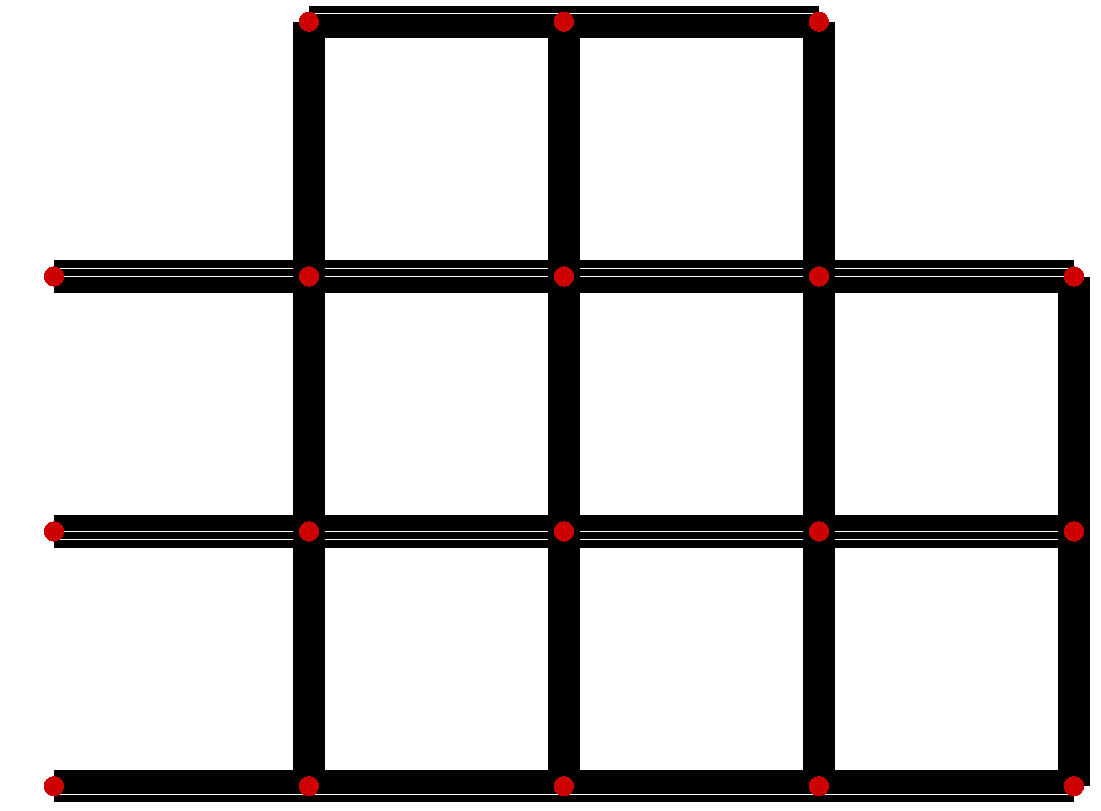

LSTM used for sequential learning

For each time step, LSTM predicts the next point

Used MinMaxScaler to scale the features

80 % Training, 20 % Test for ~66,000 rows of data

The model consists of two LSTM layers with 50 units each and a dense layer with 2 units (x,y)

Train for 10 epochs with a batch size of 64.

In [39]:

#SEQUENTIAL PROCESSING -- LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess data
file_path = 'extended_fcd_output.csv'
df = pd.read_csv(file_path)
scaler = MinMaxScaler(feature_range=(0, 1))
df[['x', 'y', 'speed', 'acceleration', 'angle', 'time']] = scaler.fit_transform(df[['x', 'y', 'speed', 'acceleration', 'angle', 'time']])

# Create sequences for LSTM
timesteps = 5
X, y, vehicle_ids = [], [], []
for vehicle_id in df['id'].unique():
    vehicle_df = df[df['id'] == vehicle_id]
    for i in range(len(vehicle_df) - timesteps):
        X.append(vehicle_df.iloc[i:i+timesteps][['x', 'y', 'speed', 'acceleration', 'angle', 'time']].values)
        y.append(vehicle_df.iloc[i + timesteps][['x', 'y']].values)
        vehicle_ids.append(vehicle_id)

X, y, vehicle_ids = np.array(X), np.array(y), np.array(vehicle_ids)


# Convert the lists to numpy arrays and ensure the type is float32
X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')
vehicle_ids = np.array(vehicle_ids, dtype='float32') # If needed, convert vehicle IDs too

# Split data into training and testing sets
X_train, X_test, y_train, y_test, vehicle_ids_train, vehicle_ids_test = train_test_split(X, y, vehicle_ids, test_size=0.2, random_state=42)


# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(2))  # Predicting 'x' and 'y' coordinates

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)



##### Combine GNN

Epoch 1/10
788/788 [==============================] - 12s 11ms/step - loss: 0.0048 - val_loss: 2.6015e-04
Epoch 2/10
788/788 [==============================] - 9s 12ms/step - loss: 1.6681e-04 - val_loss: 1.3789e-04
Epoch 3/10
788/788 [==============================] - 9s 12ms/step - loss: 1.1810e-04 - val_loss: 9.6714e-05
Epoch 4/10
788/788 [==============================] - 9s 11ms/step - loss: 9.0658e-05 - val_loss: 7.3039e-05
Epoch 5/10
788/788 [==============================] - 8s 11ms/step - loss: 7.6901e-05 - val_loss: 5.7544e-05
Epoch 6/10
788/788 [==============================] - 8s 10ms/step - loss: 5.3689e-05 - val_loss: 4.0916e-05
Epoch 7/10
788/788 [==============================] - 8s 11ms/step - loss: 3.1878e-05 - val_loss: 5.5729e-05
Epoch 8/10
788/788 [==============================] - 8s 10ms/step - loss: 2.2017e-05 - val_loss: 4.5669e-05
Epoch 9/10
788/788 [==============================] - 8s 11ms/step - loss: 2.1784e-05 - val_loss: 3.1646e-05
Epoch 10/10
394/394 [=

In [2]:


# Assume y_true are the true values and y_pred are the model's predictions
# y_true is [actual values]
# y_pred is [model's predictions]

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Here y_test are the true values and y_pred are the model's predictions
# These should be obtained from your actual model's predictions

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Print the results
print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

MSE: 3.6067645851289853e-05, RMSE: 0.0059750135987997055, MAE: 0.004938500467687845


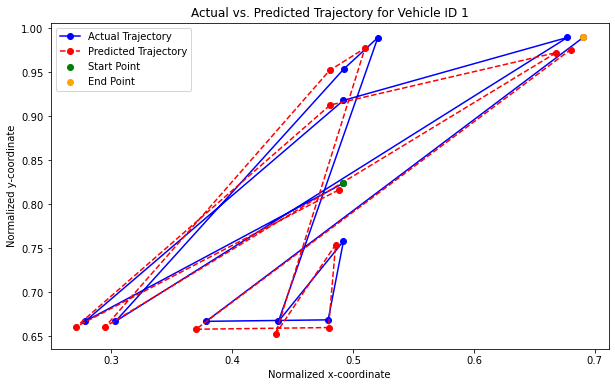

In [5]:
# Plot actual vs. predicted trajectories for a specific vehicle ID
vehicle_id_to_plot = 1  # Replace with the vehicle ID you want to analyze
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_trajectories = y_test[indices_to_plot]
predicted_trajectories = y_pred[indices_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(actual_trajectories[:, 0], actual_trajectories[:, 1], 'o-', label='Actual Trajectory', color='blue')
plt.plot(predicted_trajectories[:, 0], predicted_trajectories[:, 1], 'o--', label='Predicted Trajectory', color='red')
#plt.gca().set_aspect('equal', adjustable='box')  # This ensures that the scale is the same on both axes

# Marking the starting and ending points
plt.scatter(actual_trajectories[0, 0], actual_trajectories[0, 1], color='green', label='Start Point', zorder=5)
plt.scatter(actual_trajectories[-1, 0], actual_trajectories[-1, 1], color='orange', label='End Point', zorder=5)

plt.title(f'Actual vs. Predicted Trajectory for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('Normalized x-coordinate')
plt.ylabel('Normalized y-coordinate')
plt.legend()
plt.show()

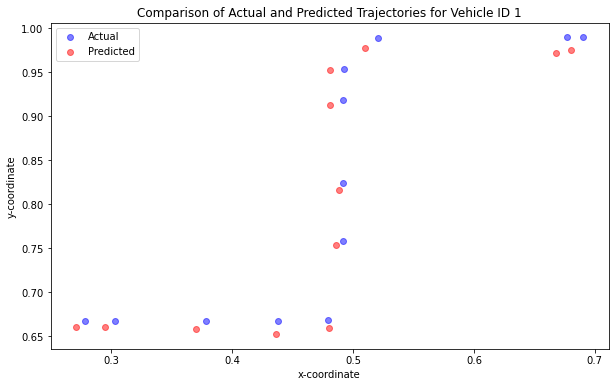

In [33]:
import matplotlib.pyplot as plt

# Define the vehicle ID you want to plot
vehicle_id_to_plot = 1
# Replace with the desired vehicle ID

# Filter the data for the specified vehicle
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_data = y_test[indices_to_plot]
predicted_data = y_pred[indices_to_plot]

# Set the x and y limits for the plot
xlim = (0.2, 0.8)  # Adjust these limits as needed
ylim = (0.2, 0.8)  # Adjust these limits as needed

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_data[:, 0], actual_data[:, 1], c='b', alpha=0.5, label='Actual')
plt.scatter(predicted_data[:, 0], predicted_data[:, 1], c='r', alpha=0.5, label='Predicted')



plt.title(f'Comparison of Actual and Predicted Trajectories for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.legend()
plt.show()

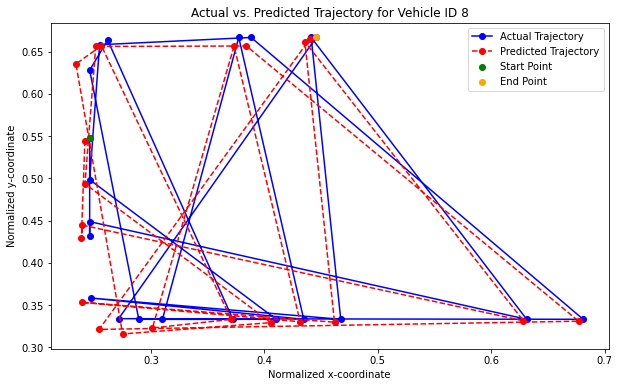

In [34]:
# Plot actual vs. predicted trajectories for a specific vehicle ID
vehicle_id_to_plot = 8  # Replace with the vehicle ID you want to analyze
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_trajectories = y_test[indices_to_plot]
predicted_trajectories = y_pred[indices_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(actual_trajectories[:, 0], actual_trajectories[:, 1], 'o-', label='Actual Trajectory', color='blue')
plt.plot(predicted_trajectories[:, 0], predicted_trajectories[:, 1], 'o--', label='Predicted Trajectory', color='red')

# Marking the starting and ending points
plt.scatter(actual_trajectories[0, 0], actual_trajectories[0, 1], color='green', label='Start Point', zorder=5)
plt.scatter(actual_trajectories[-1, 0], actual_trajectories[-1, 1], color='orange', label='End Point', zorder=5)

plt.title(f'Actual vs. Predicted Trajectory for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('Normalized x-coordinate')
plt.ylabel('Normalized y-coordinate')
plt.legend()
plt.show()

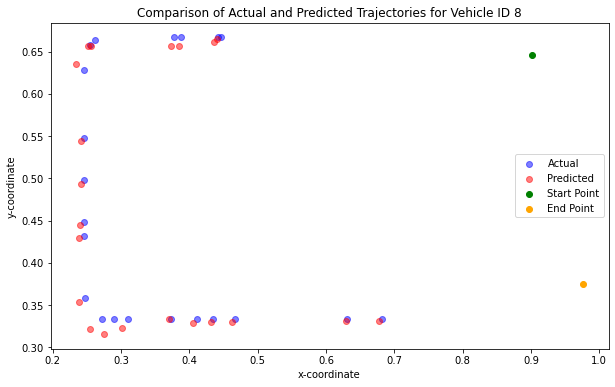

In [20]:
import matplotlib.pyplot as plt

# Define the vehicle ID you want to plot
vehicle_id_to_plot = 8  # Replace with the desired vehicle ID

# Filter the data for the specified vehicle
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_data = y_test[indices_to_plot]
predicted_data = y_pred[indices_to_plot]

# Set the x and y limits for the plot
xlim = (0.2, 0.8)  # Adjust these limits as needed
ylim = (0.2, 0.8)  # Adjust these limits as needed

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_data[:, 0], actual_data[:, 1], c='b', alpha=0.5, label='Actual')
plt.scatter(predicted_data[:, 0], predicted_data[:, 1], c='r', alpha=0.5, label='Predicted')

# Set the x and y limits
# plt.xlim(xlim)
# plt.ylim(ylim)

# # Add starting point marker (assuming it's the first data point)
# plt.scatter(actual_data[0, 0], actual_data[0, 1], c='g', marker='o', s=100, label='Start', edgecolors='k', zorder=5)

# # Add ending point marker (assuming it's the last data point)
# plt.scatter(actual_data[-1, 0], actual_data[-1, 1], c='m', marker='s', s=100, label='End', edgecolors='k', zorder=5)

# Marking the starting and ending points
plt.scatter(actual_trajectories[0, 0], actual_trajectories[0, 1], color='green', label='Start Point', zorder=5)
plt.scatter(actual_trajectories[-1, 0], actual_trajectories[-1, 1], color='orange', label='End Point', zorder=5)

plt.title(f'Comparison of Actual and Predicted Trajectories for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.legend()
plt.show()

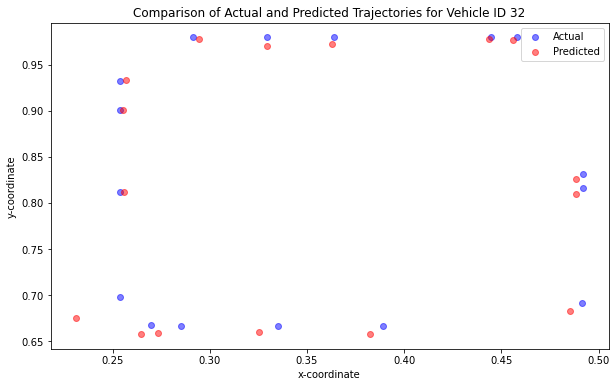

In [38]:
import matplotlib.pyplot as plt

# Define the vehicle ID you want to plot
vehicle_id_to_plot = 32  # Replace with the desired vehicle ID

# Filter the data for the specified vehicle
indices_to_plot = vehicle_ids_test == vehicle_id_to_plot
actual_data = y_test[indices_to_plot]
predicted_data = y_pred[indices_to_plot]

# Set the x and y limits for the plot
xlim = (0.2, 0.8)  # Adjust these limits as needed
ylim = (0.2, 0.8)  # Adjust these limits as needed

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_data[:, 0], actual_data[:, 1], c='b', alpha=0.5, label='Actual')
plt.scatter(predicted_data[:, 0], predicted_data[:, 1], c='r', alpha=0.5, label='Predicted')


plt.title(f'Comparison of Actual and Predicted Trajectories for Vehicle ID {vehicle_id_to_plot}')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.legend()
plt.show()


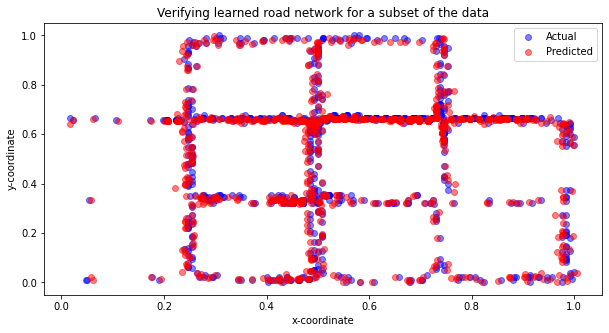

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assume y_test and y_pred are reshaped/flattened appropriately if necessary
plt.figure(figsize=(10, 5))

# Plot a random subset of the data to reduce overplotting
subset_indices = np.random.choice(np.arange(len(y_test)), size=1000, replace=False)
plt.scatter(y_test[subset_indices, 0], y_test[subset_indices, 1], c='b', alpha=0.5, label='Actual')
plt.scatter(y_pred[subset_indices, 0], y_pred[subset_indices, 1], c='r', alpha=0.5, label='Predicted')

# Set a specific range for the x and y axes to zoom in on the area of interest
# plt.xlim(0.2, 0.8)  # adjust these limits to zoom in on the area where most data points lie
# plt.ylim(0.2, 0.8)  # adjust these limits as well

plt.title('Verifying learned road network for a subset of the data')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.legend()
plt.show()

In [3]:
# This is the vehicle ID 
vehicle_id_of_interest = 1 

# Assuming vehicle_ids_test is an array with the same length as X_test and y_test,
# and it contains the vehicle ID for each sample.
indices_of_interest = (vehicle_ids_test == vehicle_id_of_interest)

# Filter X_test for the specific vehicle ID
X_test_single_vehicle = X_test[indices_of_interest]

# Filter y_test for the specific vehicle ID
y_test_single_vehicle = y_test[indices_of_interest]


In [4]:
# Parameters for prediction consistency check
consistent_prediction_start = None
consistent_predictions = 0
threshold_distance = 341  
consistency_requirement = 10  
time_interval = 1  # The time interval between data points

# Loop over the test data for the single vehicle
for i in range(len(X_test_single_vehicle)):
    current_sequence = np.expand_dims(X_test_single_vehicle[i], axis=0)
    predicted_destination = model.predict(current_sequence)
    
    # If scaler was fit on the entire dataset including 'x' and 'y',
    # inverse_transform will expect an array with the same number of features.
    # Here we are assuming 'x' and 'y' are the first two features.
    # We reshape the prediction to match the number of features the scaler was trained on.
    temp = np.zeros((1, scaler.scale_.shape[0]))
    temp[:, :2] = predicted_destination
    predicted_destination_unscaled = scaler.inverse_transform(temp)[:, :2]
    
    # Calculate the Euclidean distance from the predicted to the actual final destination
    distance = np.sqrt(np.sum((predicted_destination_unscaled - y_test_single_vehicle[i])**2))
    
    # Check if the prediction is within the threshold
    if distance <= threshold_distance:
        if consistent_prediction_start is None:
            consistent_prediction_start = i  # Record the first timestep of consistent prediction
        consistent_predictions += 1
        if consistent_predictions >= consistency_requirement:
            # Calculate the actual time of prediction
            actual_time_of_prediction = consistent_prediction_start * time_interval
            print(f"Model started consistently predicting within {threshold_distance} meters, {consistency_requirement} times")
            
            break
    else:
        # Reset if the prediction goes out of the threshold
        consistent_prediction_start = None
        consistent_predictions = 0

if consistent_prediction_start is None:
    print("The model did not consistently predict the final destination within the threshold.")


1/1 [==============================] - 0s 20ms/step
Model started consistently predicting within 341 meters, 10 times
